In [1]:
import numpy as np
import os
import skimage.data as skidata
import skimage.io as io
from skimage import transform
import skimage.color as skicolor
import pdb
from MyLib import VAE
from MyLib import load_celebA
import torch
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.nn import functional as F
import torch.nn as nn
height,width = 224,224
image = np.zeros([height,width],dtype=np.uint8)
image.fill(90)


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


(191, 129)
(224, 224, 3)


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


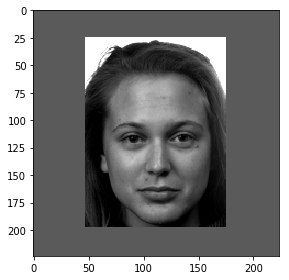

In [4]:
path = '/home/ubuntu/wkhan/VAE/dataset/2k_face_stimulus_set_high/'

a = os.listdir(path)

for image in


img = skidata.load(path+a[0])
#img[1,1]


#print (img[0,0])
shape = img.shape

print (img.shape)


image[(height-shape[0])//2:(height+shape[0])//2,(width-shape[1])//2:(width+shape[1])//2] = img
#io.imshow(img[:150,:100])
#io.imshow(image)

#image.resize(64,64)

#io.imshow(image)

image = skicolor.grey2rgb(image)

print(image.shape)
io.imshow(image)

#image[]


In [44]:
path = '/home/ubuntu/wkhan/VAE/dataset/2k_face_stimulus_set_high/'

save_path = '/home/ubuntu/wkhan/VAE/dataset/new_2k_face/'
height, width = 224,224
whole_img = np.zeros([height,width],dtype=np.uint8)


#%debug
for name in os.listdir(path):
    #pdb.set_trace()
    img_path = path+name
    image = skidata.load(img_path)
    shape = image.shape
    whole_img[(height-shape[0])//2:(height+shape[0])//2, (width-shape[1])//2:(width+shape[1])//2] = image
    io.imsave(save_path+name.split('.')[0]+'.png',whole_img)
    whole_img.fill(90)
   
    
    

KeyboardInterrupt: 

In [2]:
model_test = VAE.DC_VAE()
#pdb.set_trace()
model_test = model_test.cuda()
model_test.load_state_dict(torch.load('DFC_VAE_100epoch.pt'))

descriptor = VAE.pre_trained_vgg()
descriptor.cuda()

def loss_function(recon_x,x,mu,logvar):
    BCE = F.binary_cross_entropy(recon_x,x.view(-1,4096))
    KLD = -.5 * torch.sum(1+logvar-mu.pow(2)-logvar.exp())
    KLD /= 128*4096
    #pdb.set_trace()
    KLD = KLD 
    return BCE+KLD, BCE, KLD

bce_loss = nn.MSELoss()
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)
        
mse = nn.MSELoss()
def fpl_criterion(recon_features, targets):
    fpl = 0
    for f, target in zip(recon_features, targets):
        fpl += mse(f, target.detach())#.div(f.size(1))
    return fpl        
        

In [3]:
sample = Variable(torch.randn(64,32))
sample = sample.cuda()
model_test = model_test.cuda()
sample = model_test.decoder(sample).cpu()
save_image(sample.data.view(64,1,64,64),'recon_result/samp__qwq_11111.png')


In [ ]:
cell_loader,train,test = load_celebA.facial_dataset()
linear_model = VAE.Linear_model()
linear_model.apply(weights_init)
linear_model = linear_model.cuda()

#%debug
params = list(linear_model.parameters()) + list(model_test.parameters())

optimizer = torch.optim.Adam(params,lr = 1e-5)
for epoch in range(10):
    model_test.train()
    optimizer.zero_grad()
    for batch_idx,data in enumerate(cell_loader):
    #model_test.train()
        image = Variable(data['image']).float().view(-1,1,64,64).cuda()
        cell_acti = Variable(data['cell']).float().cuda()
        
        image_3d = image.expand(-1,3,-1,-1)
        vgg_feature = descriptor(image_3d)
        
        recon_batch,mu,logvar,z = model_test(image)
        recon_batch = recon_batch.view(-1,1,64,64)
        recon_batch_3d = recon_batch.expand(-1,3,-1,-1)
        recon_feature = descriptor(recon_batch_3d)
        
        
        Linear_cell = linear_model(z)
        cell_loss = bce_loss(Linear_cell,cell_acti)
        cell_loss.backward(retain_graph=True)
        
        loss,bce,kld = loss_function(recon_batch, image, mu, logvar)
        #kld.backward(retain_graph=True)
        
        perception_loss = fpl_criterion(recon_feature,vgg_feature)
        
        perception_loss.backward()
        
        optimizer.step()
        recon_batch = recon_batch.cpu()
        image = image.cpu()
        if (epoch%1 == 0):
            save_image(recon_batch.data.view(-1,1,64,64),
                      'RESULTS/temp_result/'+'recon'+str(batch_idx)+'epoch'+str(epoch)+'.png')
            save_image(image.data.view(-1,1,64,64),
                      'RESULTS/temp_result/'+str(batch_idx)+'epoch'+str(epoch)+'.png')
            arr = z.data.cpu().numpy()
            np.savetxt('RESULTS/temp_result/' + str(batch_idx)+'epoch'+str(epoch)+'.csv',arr)
    print ('epoch'+str(epoch))
    
    


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([128, 4096])) that is different to the input size (torch.Size([128, 1, 64, 64])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([114, 4096])) that is different to the input size (torch.Size([114, 1, 64, 64])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


epoch0
epoch1
epoch2
epoch3
epoch4
epoch5
epoch6
epoch7
epoch8


In [27]:
save_image(recon_batch.data.view(-1,1,64,64),
                      'RESULTS/'+'recon'+str(batch_idx)+'epoch'+str(epoch)+'.png')
save_image(image.data.view(-1,1,64,64),
                      'RESULTS/'+str(batch_idx)+'epoch'+str(epoch)+'.png')
arr = z.data.cpu().numpy()
np.savetxt('RESULTS/' + str(batch_idx)+'epoch'+str(epoch)+'.csv',arr)